# Global Path Variables

In [ ]:
base_path = "drive/MyDrive/Medical Data/"
EDA = "drive/MyDrive/Medical Data/EDA/"
pre_processing = "drive/MyDrive/Medical Data/PreProcessing/"
vgg19 = "/content/drive/MyDrive/Medical Data/VGG19/"

# Import Necessary Libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import h5py
from tqdm import tqdm
import cv2
import gc

# Importing Deep learning Libraries
import tensorflow as tf
print(tf.__version__)
from tensorflow import keras

from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, load_model, Model
from keras.layers import (InputLayer, BatchNormalization, Dropout, Flatten,
                                     Dense, Activation, MaxPool2D, GlobalAveragePooling2D,
                                     Conv2D, MaxPooling2D)
from keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler, Callback, ReduceLROnPlateau
from keras import optimizers, Input
from keras.utils import plot_model
from keras.applications.imagenet_utils import decode_predictions
from keras.optimizers import Adam, RMSprop
from keras.metrics import Precision, Recall, AUC
from keras.backend import clear_session

# Pretrained model preprocess
from keras.applications.vgg19 import preprocess_input as vgg19_preprocess
from keras.applications.inception_v3 import preprocess_input as inception_preprocess
from keras.applications.xception import preprocess_input as xception_preprocess
from keras.applications.resnet import preprocess_input as resnet50_preprocess

# Pretrained models
from keras.applications.xception import Xception
from keras.applications.inception_v3 import InceptionV3
from keras.applications.vgg19 import VGG19
from keras.applications.resnet import ResNet50


# Image read and show
import skimage.io
from skimage.io import imread, imshow

# Metrics
from sklearn.metrics import f1_score , recall_score, accuracy_score, precision_score, confusion_matrix
from sklearn.metrics import roc_curve, auc, classification_report
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from itertools import cycle

2.12.0


In [ ]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Limit memory growth for the GPU
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

# Load the Dataset from h5 file..


In [ ]:
def load_hdf5_data(hdf5_path):
    f = h5py.File(hdf5_path, 'r')
    return f['image'], f['image_name'], f['image_label']

train_images, train_names, train_labels = load_hdf5_data(f'{base_path}Dataset5_raw_train.h5')
val_images, val_names, val_labels = load_hdf5_data(f'{base_path}Dataset5_raw_val.h5')
test_images, test_names, test_labels = load_hdf5_data(f'{base_path}Dataset5_raw_test.h5')

In [ ]:
print(f"train_images shape and dtype : {train_images.shape} , {train_images.dtype} and train_labels shape and dtype : {train_labels.shape} , {train_labels.dtype}")
print(f"val_images shape : {val_images.shape} and train_labels shape : {val_labels.shape}")
print(f"test_images shape : {test_images.shape} and train_labels shape : {test_labels.shape}")

train_images shape and dtype : (19610, 224, 224, 3) , float16 and train_labels shape and dtype : (19610, 1) , float64
val_images shape : (6534, 224, 224, 3) and train_labels shape : (6534, 1)
test_images shape : (6540, 224, 224, 3) and train_labels shape : (6540, 1)


In [ ]:
def get_label_counts(labels):
    # Convert the HDF5 dataset to a numpy array first
    labels_np = np.array(labels)

    # Get the unique labels and their counts
    unique_labels, counts = np.unique(labels_np, return_counts=True)

    # Create a dictionary of label to count
    label_counts = dict(zip(unique_labels, counts))

    return label_counts

train_label_counts = get_label_counts(train_labels)
val_label_counts = get_label_counts(val_labels)
test_label_counts = get_label_counts(test_labels)

print("Training label counts:", train_label_counts)
print("Validation label counts:", val_label_counts)
print("Test label counts:", test_label_counts)


Training label counts: {0.0: 2512, 1.0: 3607, 2.0: 6115, 3.0: 4438, 4.0: 2938}
Validation label counts: {0.0: 836, 1.0: 1202, 2.0: 2038, 3.0: 1479, 4.0: 979}
Test label counts: {0.0: 838, 1.0: 1203, 2.0: 2039, 3.0: 1480, 4.0: 980}


# Class Label to Disease Name Mapping Dict

In [ ]:
"""
COVID-19 :  4,189 : 0
Lung-Opacity : 6,012 : 1
Normal : 10,192 : 2
Viral Pneumonia : 7,397 : 3
Tuberculosis : 4,897 : 4
"""

Label_ClassName_Dict = {
    0 : "COVID-19",
    1 : "Lung-Opacity",
    2 : "Normal",
    3 : "Viral Pneumonia",
    4 : "Tuberculosis",
}

ClassName_Dict_Label  = {v: k for k, v in Label_ClassName_Dict.items()}

float32 0.08630371 0.7841797 (224, 224, 3) 3
float32 0.0 0.80371094 (224, 224, 3) 3
float32 0.003921509 1.0 (224, 224, 3) 3
float32 0.0 0.9135742 (224, 224, 3) 3
float32 0.1607666 0.8276367 (224, 224, 3) 3


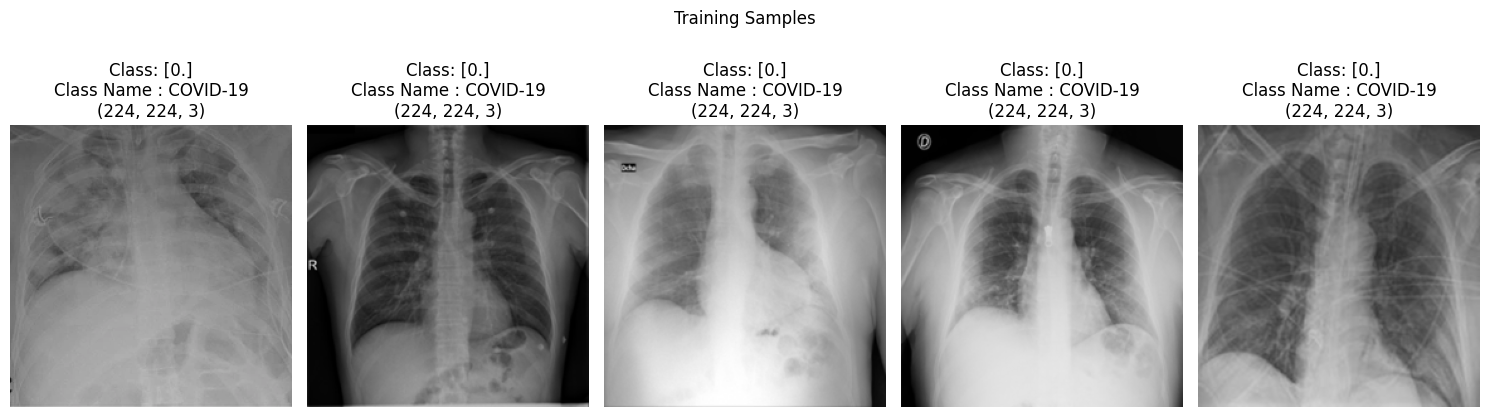

<Figure size 640x480 with 0 Axes>

In [ ]:
def display_samples(images, labels, path, num_samples=5, Type = "Training"):
    plt.figure(figsize=(15, 5))
    for i in range(num_samples):
        ax = plt.subplot(1, num_samples, i + 1)
        image = images[i]
        # Normalize the image if its values are not in the range [0, 1]
        # Convert the image to a suitable dtype
        if image.max() > 1:
            image = (image / 255.0).astype(np.float32)
        else:
            image = image.astype(np.float32)
        print(image.dtype, image.min(), image.max(), image.shape, len(image.shape))
        plt.imshow(image, cmap='gray' if len(image.shape) == 2 else None) # Use gray colormap if the image is grayscale
        plt.title(f'Class: {labels[i]}\n' + f'Class Name : {Label_ClassName_Dict[int(labels[i].squeeze())]}\n' + f"{image.shape}")
        plt.axis('off')

    plt.suptitle(f"{Type} Samples")
    plt.tight_layout()
    plt.show()
    plt.savefig(path)

display_samples(train_images, train_labels, f"{pre_processing}Image_Samples.png")

# Image Pre-processing
1. CLAHE with grid size of 15 and clip size of 2.
2. Image Shapening with kernels.
3. Hybrid CLAHE + Image Sharpening

In [ ]:
"""
CLAHE
"""

# Function to apply CLAHE
def apply_clahe(img, grid_size=15, clip_limit=2.0):
    img = img.numpy()  # Convert tensor to numpy array
    img = img.astype(np.uint8)
    grid_size = int(grid_size)
    clahe = cv2.createCLAHE(clipLimit=float(clip_limit), tileGridSize=(grid_size, grid_size))
    img_clahe = np.zeros_like(img)
    for channel in range(3):
        img_clahe[..., channel] = clahe.apply(img[..., channel])
    return img_clahe

"""
Image Shapening
"""

# kernels = [[[ 0,-1, 0],[-1, 5,-1],[ 0,-1, 0]], # Basic Sharpening Kernel:
#            [[ 0, 1, 0],[ 1,-4, 1],[ 0, 1, 0]], # Laplacian Sharpening Kernel:
#            [[-1, 0,-1],[ 0, 8, 0],[-1, 0,-1]], # Diagonal Edge Sharpening:
#            [[-1,-1,-1],[-1, 9,-1],[-1,-1,-1]], # Exaggerated Sharpening:
#            [[ 1, 1, 1],[ 1,-7, 1],[ 1, 1, 1]], # Another variant of Laplacian:
# ]

kernels = {
    "Basic Sharpening Kernel" : np.array([[ 0,-1, 0],[-1, 5,-1],[ 0,-1, 0]]),
    "Laplacian Sharpening Kernel" : np.array([[ 0, 1, 0],[ 1,-4, 1],[ 0, 1, 0]]),
    "Diagonal Edge Sharpening" : np.array([[-1, 0,-1],[ 0, 8, 0],[-1, 0,-1]]) ,
    "Exaggerated Sharpening" : np.array([[-1,-1,-1],[-1, 9,-1],[-1,-1,-1]]),
    "Another variant of Laplacian" : np.array([[ 1, 1, 1],[ 1,-7, 1],[ 1, 1, 1]],) ,
}

# Function to sharpen image
def sharpen_image(img, kernel= kernels["Basic Sharpening Kernel"]):
    img = img.numpy()
    img = img.astype(np.uint8)
    kernel = np.array(kernel)
    return cv2.filter2D(img, -1, kernel)

"""
Pre-Process and Visualisation Functions
"""

# Apply CLAHE and sharpening transformations only to images
def preprocess_images(image, label):
    image = tf.py_function(apply_clahe, [image], tf.uint8)
    image = tf.py_function(sharpen_image, [image], tf.uint8)
    return image, label

# Apply CLAHE only to images
def preprocess_images_clahe(image, label, grid_size=15, clip_limit=2.0):
    image = tf.py_function(apply_clahe, [image, grid_size, clip_limit], tf.uint8)
    return image, label

# Apply sharpening transformations only to images
def preprocess_images_sharpen(image, label, kernel):
    image = tf.py_function(sharpen_image, [image, kernel], tf.uint8)
    return image, label

# Visualization function
def visualize_dataset(ds, title, path):
    samples = ds.take(5)
    # print(len(list(samples)))

    plt.figure(figsize=(15, 5))
    i = 0
    for image, label in samples:
        # print(int(label.numpy().squeeze()), label.numpy().shape , len(label.numpy()))
        # print(type(image), image.shape, len(image))
        #image = tf.image.convert_image_dtype(image, dtype=tf.uint8)
        image = image.numpy()
        if image.max() > 1:
            image = (image / 255.0).astype(np.float32)
        else:
            image = image.astype(np.float32)
        # print(image.dtype, image.min(), image.max(), image.shape, len(image.shape))
        plt.subplot(1, 5, i+1)
        plt.imshow(image)
        plt.title(f"Label: {Label_ClassName_Dict[int(label.numpy().squeeze())]}")
        plt.axis('off')
        i += 1
    plt.suptitle(title)
    plt.tight_layout()
    plt.savefig(path)
    plt.show()

def visualize_dataset_for_finetuning(ds, factors, title, path, Type = "Kernel", kernels = None):
    # Type = factor , clip limit
    plt.figure(figsize=(15, len(factors)*3))

    for i, factor in enumerate(factors):
        if Type == "Clip Limit":
            modified_ds = ds.map(lambda img, label: preprocess_images_clahe(img, label, grid_size=15, clip_limit=factor), num_parallel_calls=tf.data.experimental.AUTOTUNE)
        if Type == "Kernel":
            kernel_name = list(kernels.keys())[i]
            modified_ds = ds.map(lambda img, label: preprocess_images_sharpen(img, label, kernel= kernels[kernel_name]), num_parallel_calls=tf.data.experimental.AUTOTUNE)
        if Type == "Grid Size":
            modified_ds = ds.map(lambda img, label: preprocess_images_clahe(img, label, grid_size = factor), num_parallel_calls=tf.data.experimental.AUTOTUNE)
        samples = modified_ds.take(5)

        for j, (image, label) in enumerate(samples):
            image = image.numpy()
            if image.max() > 1:
                image = (image / 255.0).astype(np.float32)
            else:
                image = image.astype(np.float32)

            plt.subplot(len(factors), 5, i*5 + j + 1)
            plt.imshow(image)
            plt.title(f"Label: {Label_ClassName_Dict[int(label.numpy().squeeze())]}\n{Type}: {factor}")
            if Type == "Kernel":
              plt.title(f"Label: {Label_ClassName_Dict[int(label.numpy().squeeze())]}\n{list(kernels.keys())[i]}")
            plt.axis('off')

    plt.suptitle(title)
    plt.tight_layout()
    plt.savefig(path)
    plt.show()

def rescale_image(img):
    return (img - img.min()) / (img.max() - img.min())

def plot_pixel_intensity_from_dataset(dataset):
    # Compute average pixel intensities
    avg_intensities = [img.numpy().mean() for img, _ in dataset]

    # Plot the histogram
    plt.hist(avg_intensities, bins=30)
    plt.legend()
    plt.title(f'Pixel Intensity Distribution.')
    plt.show()

## Create Tensorflow Datasets from HDF5 files.


In [ ]:
# Create a TF Dataset
with tf.device('/cpu:0'):
    train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_labels))
    val_dataset = tf.data.Dataset.from_tensor_slices((val_images, val_labels))
    test_dataset = tf.data.Dataset.from_tensor_slices((test_images, test_labels))

## Apply Pre-Processing

In [ ]:
with tf.device('/cpu:0'):
    # Training set Pre-Processing
    train_dataset_preprocessed = train_dataset.map(preprocess_images, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    # Validation set Pre-Processing
    val_dataset_preprocessed = val_dataset.map(preprocess_images, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    # Testing set Pre-Processing
    test_dataset_preprocessed = test_dataset.map(preprocess_images, num_parallel_calls=tf.data.experimental.AUTOTUNE)

In [ ]:
# del train_dataset , test_dataset , val_dataset
# del train_images , test_images , val_images
# del train_labels , test_labels , val_labels
# del train_names , test_names , val_names
# gc.collect()

# Set Seed

In [ ]:
Seed = 123
Batch_Size = 128
Image_Size = 224
num_classes = 5
np.random.seed(Seed)
tf.random.set_seed(Seed)

# VGG19 finetuning

1. Vgg19 preprocess

*   scaling + 0 centering
*   Normalization

2. Repeated Fine Tuning



## VGG19 pre process

In [ ]:
"""
1. vgg19 Pre Process
"""
# Scaling
def scaling(image, label):
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

## Scaling and 0 centering

In [ ]:
with tf.device('/cpu:0'):
    train_dataset_scaled = train_dataset_preprocessed.map(lambda img, lbl: scaling(img,lbl), num_parallel_calls=tf.data.experimental.AUTOTUNE)
    val_dataset_scaled = val_dataset_preprocessed.map(lambda img, lbl: scaling(img,lbl), num_parallel_calls=tf.data.experimental.AUTOTUNE)
    test_dataset_scaled = test_dataset_preprocessed.map(lambda img, lbl: scaling(img,lbl), num_parallel_calls=tf.data.experimental.AUTOTUNE)

In [ ]:
with tf.device('/cpu:0'):

    def accumulate_images(img, label):
        return tf.reduce_sum(img, axis=0), tf.shape(img)[0]

    # Map the accumulate function onto the dataset and reduce to get global sum and count
    accumulated_data = train_dataset_scaled.map(accumulate_images).reduce(
        (tf.zeros([224, 224, 3]), 0),
        lambda x, y: (x[0] + y[0], x[1] + y[1])
    )

    # Compute the mean
    mean_image = accumulated_data[0] / tf.cast(accumulated_data[1], tf.float32)


In [ ]:
# Zero-centering
def zero_center(image, label):
    return image - mean_image, label

with tf.device('/cpu:0'):
      # Apply zero-centering to the datasets
      train_dataset_scaled_centered = train_dataset_scaled.map(zero_center, num_parallel_calls=tf.data.experimental.AUTOTUNE)
      val_dataset_scaled_centered = val_dataset_scaled.map(zero_center, num_parallel_calls=tf.data.experimental.AUTOTUNE)
      test_dataset_scaled_centered = test_dataset_scaled.map(zero_center, num_parallel_calls=tf.data.experimental.AUTOTUNE)


## Normalization

In [ ]:
# total_images = 0
# mean_sum = np.zeros([224, 224, 3])
# squared_sum = np.zeros([224, 224, 3])

# for images, _ in train_dataset_preprocessed:
#     images = tf.cast(images, tf.float32) / 255.0  # Make sure the images are in float
#     total_images += images.shape[0]
#     mean_sum += tf.reduce_sum(images, axis=0).numpy()
#     squared_sum += tf.reduce_sum(tf.square(images), axis=0).numpy()

# dataset_mean = mean_sum / total_images
# dataset_variance = (squared_sum / total_images) - np.square(dataset_mean)
# dataset_std = np.sqrt(dataset_variance)

In [ ]:
# def normalize_img(image, label):
#     image = tf.cast(image, tf.float32) / 255.0
#     normalized_image = (image - dataset_mean) / dataset_std
#     return normalized_image, label

# train_dataset_normalized = train_dataset_preprocessed.map(normalize_img)
# val_dataset_normalized = val_dataset_preprocessed.map(normalize_img)
# test_dataset_normalized = test_dataset_preprocessed.map(normalize_img)

## Shuffling the images

In [ ]:
BUFFER_SIZE = 19610
print(f"Buffer Size : {BUFFER_SIZE}")

# train_dataset_normalized = train_dataset_normalized.shuffle(BUFFER_SIZE)
train_dataset_scaled_centered = train_dataset_scaled_centered.shuffle(BUFFER_SIZE)

Buffer Size : 19610


## Data Loader and Batching.

In [ ]:
num_classes = 5

def one_hot_encode_batched(images, labels):
    labels = tf.cast(labels, tf.int32)
    labels = tf.one_hot(labels, depth=num_classes)
    labels = tf.squeeze(labels, axis = 1)  # Remove unnecessary dimensions
    return images, labels

In [ ]:
# Scaled , 0 centered dataset Batch and Prefetch
train_dataset_scaled_centered_batched_onehot = (train_dataset_scaled_centered
                                                # .shuffle(BUFFER_SIZE)
                                                .batch(Batch_Size)
                                                .map(one_hot_encode_batched, num_parallel_calls=tf.data.experimental.AUTOTUNE)
                                                # .shuffle(BUFFER_SIZE//Batch_Size)
                                                .prefetch(tf.data.experimental.AUTOTUNE))

val_dataset_scaled_centered_batched_onehot = (val_dataset_scaled_centered
                                              # .shuffle(BUFFER_SIZE)
                                              .batch(Batch_Size)
                                              .map(one_hot_encode_batched, num_parallel_calls=tf.data.experimental.AUTOTUNE)
                                              # .shuffle(BUFFER_SIZE//Batch_Size)
                                              .prefetch(tf.data.experimental.AUTOTUNE))

test_dataset_scaled_centered_batched_onehot = (test_dataset_scaled_centered
                                                # .shuffle(BUFFER_SIZE)
                                                .batch(Batch_Size)
                                                .map(one_hot_encode_batched, num_parallel_calls=tf.data.experimental.AUTOTUNE)
                                                # .shuffle(BUFFER_SIZE//Batch_Size)
                                                .prefetch(tf.data.experimental.AUTOTUNE))

In [ ]:
# # Normalised dataset Batch and Prefetch
# train_dataset_normalized_batched_onehot = (train_dataset_normalized
#                                                 # .shuffle(BUFFER_SIZE)
#                                                 .batch(Batch_Size)
#                                                 .map(one_hot_encode_batched, num_parallel_calls=tf.data.experimental.AUTOTUNE)
#                                                 # .shuffle(BUFFER_SIZE//Batch_Size)
#                                                 .prefetch(tf.data.experimental.AUTOTUNE))

# val_dataset_normalized_batched_onehot = (val_dataset_normalized
#                                               # .shuffle(BUFFER_SIZE)
#                                               .batch(Batch_Size)
#                                               .map(one_hot_encode_batched, num_parallel_calls=tf.data.experimental.AUTOTUNE)
#                                               # .shuffle(BUFFER_SIZE//Batch_Size)
#                                               .prefetch(tf.data.experimental.AUTOTUNE))

# test_dataset_normalized_batched_onehot = (test_dataset_normalized
#                                                 # .shuffle(BUFFER_SIZE)
#                                                 .batch(Batch_Size)
#                                                 .map(one_hot_encode_batched, num_parallel_calls=tf.data.experimental.AUTOTUNE)
#                                                 # .shuffle(BUFFER_SIZE//Batch_Size)
#                                                 .prefetch(tf.data.experimental.AUTOTUNE))

## Fine Tuning train_dataset_scaled_centered_batched_onehot Dataset.


In [ ]:
def Confusion_Matrix_Heatmap(y_test,y_pred,class_Names, fName, ModelName):
    #Plot the confusion matrix to understand the classification in detail
    CM = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(10, 8), dpi=80, facecolor='w', edgecolor='k')
    ax = sns.heatmap(CM, cmap='Greens', annot=True, fmt='d', xticklabels=class_Names, yticklabels=class_Names)
    plt.title(f'Disease Diagnosis from CXR images - {ModelName}')
    plt.xlabel('Prediction')
    plt.ylabel('Truth')
    plt.savefig(f"{vgg19}{fName}")
    #plt.show(ax)

# Plot Evaluation Metrics
# sns.set_style('darkgrid')
#plt.style.use('fivethirtyeight')
def Eval_Plot(acc,val_acc, loss,val_loss, auc, val_auc, precision, val_precision, path, title):

    fig, (ax1,ax2,ax3,ax4) = plt.subplots(1,4, figsize= (20,5))
    fig.suptitle(f"{title}\n", fontsize = 15)

    ax1.plot(range(1, len(acc) + 1), acc)
    ax1.plot(range(1, len(val_acc) + 1), val_acc)
    ax1.set_title('History of Accuracy', fontsize = 15)
    ax1.set_xlabel('Epochs', fontsize = 15)
    ax1.set_ylabel('Accuracy', fontsize = 15)
    ax1.legend(['Training', 'Validation'], fontsize = 15)


    ax2.plot(range(1, len(loss) + 1), loss)
    ax2.plot(range(1, len(val_loss) + 1), val_loss)
    ax2.set_title('History of Loss', fontsize = 15)
    ax2.set_xlabel('Epochs', fontsize = 15)
    ax2.set_ylabel('Loss', fontsize = 15)
    ax2.legend(['Training', 'Validation'], fontsize = 15)

    ax3.plot(range(1, len(auc) + 1), auc)
    ax3.plot(range(1, len(val_auc) + 1), val_auc)
    ax3.set_title('History of AUC', fontsize = 15)
    ax3.set_xlabel('Epochs', fontsize = 15)
    ax3.set_ylabel('AUC', fontsize = 15)
    ax3.legend(['Training', 'Validation'], fontsize = 15)

    ax4.plot(range(1, len(precision) + 1), precision)
    ax4.plot(range(1, len(val_precision) + 1), val_precision)
    ax4.set_title('History of Precision', fontsize = 15)
    ax4.set_xlabel('Epochs', fontsize = 15)
    ax4.set_ylabel('Precision', fontsize = 15)
    ax4.legend(['Training', 'Validation'], fontsize = 15)

    plt.savefig(f"{vgg19}{path}")
    #plt.show()

In [ ]:
# GCW : Global Class Based Weighting
total_samples = 2512 + 3607 + 6115 + 4438 + 2938

# Calculate the global class-based weights
weights = {
    'COVID-19':  total_samples / (num_classes * 2512),
    'Lung-Opacity':  total_samples / (num_classes * 3607),
    'Normal':  total_samples / (num_classes * 6115),
    'Viral Pneumonia':  total_samples / (num_classes * 4438),
    'Tuberculosis':  total_samples / (num_classes * 2938)
}

int_weights = {ClassName_Dict_Label[key]: value for key, value in weights.items()}
print(int_weights)

{0: 1.5613057324840764, 1: 1.0873301912947047, 2: 0.6413736713000817, 3: 0.8837314105452907, 4: 1.334921715452689}


In [ ]:
steps_per_epoch = total_samples // Batch_Size
print('steps per epoch: ',steps_per_epoch + 1)

steps per epoch:  154


## Delete un-necessary Files to free up System Ram.

In [ ]:
# del dataset_mean , dataset_std, dataset_variance
# del mean_image, mean_sum , squared_sum
# del test_images, test_dataset, test_dataset_normalized, test_dataset_preprocessed, test_dataset_scaled, test_dataset_scaled_centered
# del train_images, train_dataset, train_dataset_normalized, train_dataset_preprocessed, train_dataset_scaled, train_dataset_scaled_centered
# del val_images, val_dataset, val_dataset_normalized, val_dataset_preprocessed, val_dataset_scaled, val_dataset_scaled_centered
# del test_labels, train_labels, val_labels

In [ ]:
# del train_names, val_names, test_names
# gc.collect()

### Clear Keras Backend

In [ ]:
tf.keras.backend.clear_session()

### Load the Pre-trained VGG19 Model:


In [ ]:
base_model = VGG19(include_top=False, weights='imagenet', input_shape=(224, 224, 3))

80134624/80134624 [==============================] - 3s 0us/step


### Classification layer architecture

In [ ]:
# x = base_model.output
# x = Flatten()(x)

# # First dense layer
# x = Dense(1024)(x)
# x = BatchNormalization()(x)
# x = Activation('relu')(x)
# x = Dropout(0.5)(x)  # Adding dropout for regularization

# # Second dense layer
# x = Dense(512)(x)
# x = BatchNormalization()(x)
# x = Activation('relu')(x)
# x = Dropout(0.5)(x)

# # Optional: Third dense layer, can be tested for performance
# x = Dense(256)(x)
# x = BatchNormalization()(x)
# x = Activation('relu')(x)
# x = Dropout(0.5)(x)

# # Final dense layer with softmax for classification
# predictions = Dense(5, activation='softmax')(x)

# Add a GAP layer
x = GlobalAveragePooling2D()(base_model.output)

# Add a fully connected layer with dropout for regularization
x = Dense(4096, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(4096, activation='relu')(x)

# Add the final softmax layer for classification
predictions = Dense(num_classes, activation='softmax')(x)


with tf.device('/gpu:0'):
    model = Model(inputs=base_model.input, outputs=predictions)

In [ ]:
METRICS = [
      keras.metrics.CategoricalAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
]

In [ ]:
with tf.device('/gpu:0'):
    model.compile(optimizer=Adam(learning_rate=0.0001),
                  loss='categorical_crossentropy',
                  metrics=METRICS)
    #Freeze the base model to train only the top layers
    for layer in base_model.layers:
        layer.trainable = False

    ###################################################################################

    early_stopping_cb = EarlyStopping(
        monitor='val_auc',           # Which metric to monitor.
        patience=5,                  # Number of epochs with no improvement after which training will be stopped.
        restore_best_weights=True,    # Whether to restore model weights from the epoch with the best value of the monitored quantity.
        verbose=1                     # Logging level. 1 = print logs.
    )

    lr_reduce = ReduceLROnPlateau(monitor='val_auc',
                                  factor=0.5,
                                  patience=5,
                                  verbose=1,
                                  mode='max',
                                  min_lr=0.00000001)

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

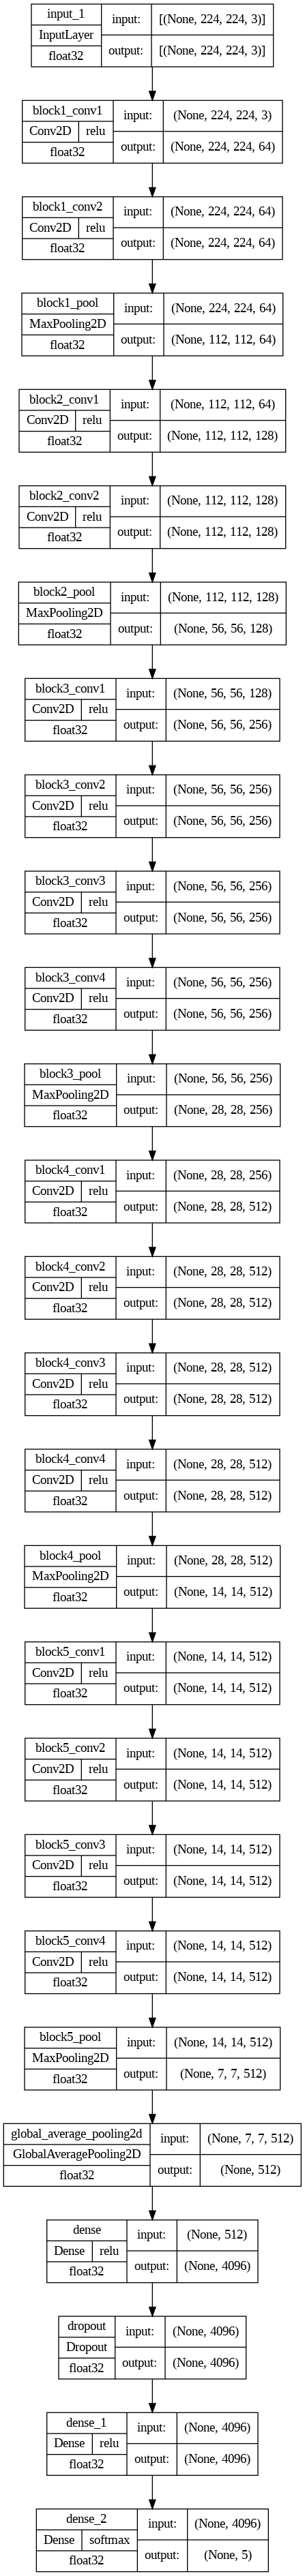

In [ ]:
plot_model(
    model,
    to_file=f"drive/MyDrive/Medical Data/VGG19/Architecture_VGG19.png",
    show_shapes=True,
    show_dtype=True,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=False,
    dpi=96,
    layer_range=None,
    show_layer_activations=True,
)


In [ ]:
with tf.device('/gpu:0'):
    epochs = 30
    # Train the model using the fold data
    history_vgg19_scaled_batched = model.fit(train_dataset_scaled_centered_batched_onehot,
                                            validation_data=val_dataset_scaled_centered_batched_onehot,
                                            epochs=epochs,
                                            verbose = 1,
                                            class_weight=int_weights,
                                            callbacks=[early_stopping_cb, lr_reduce])


Epoch 1/30
154/154 [==============================] - 119s 379ms/step - loss: 1.2120 - accuracy: 0.5011 - precision: 0.7375 - recall: 0.2925 - auc: 0.7992 - val_loss: 0.6906 - val_accuracy: 0.7368 - val_precision: 0.8014 - val_recall: 0.6455 - val_auc: 0.9393 - lr: 1.0000e-04
Epoch 2/30
154/154 [==============================] - 95s 348ms/step - loss: 1.1298 - accuracy: 0.5659 - precision: 0.7611 - recall: 0.3770 - auc: 0.8460 - val_loss: 0.8923 - val_accuracy: 0.6489 - val_precision: 0.7479 - val_recall: 0.5084 - val_auc: 0.8987 - lr: 1.0000e-04
Epoch 3/30
154/154 [==============================] - 95s 350ms/step - loss: 0.8889 - accuracy: 0.6745 - precision: 0.7659 - recall: 0.5527 - auc: 0.9101 - val_loss: 0.6610 - val_accuracy: 0.7547 - val_precision: 0.7904 - val_recall: 0.7138 - val_auc: 0.9445 - lr: 1.0000e-04
Epoch 4/30
154/154 [==============================] - 95s 349ms/step - loss: 0.6166 - accuracy: 0.7874 - precision: 0.8336 - recall: 0.7306 - auc: 0.9554 - val_loss: 1.532

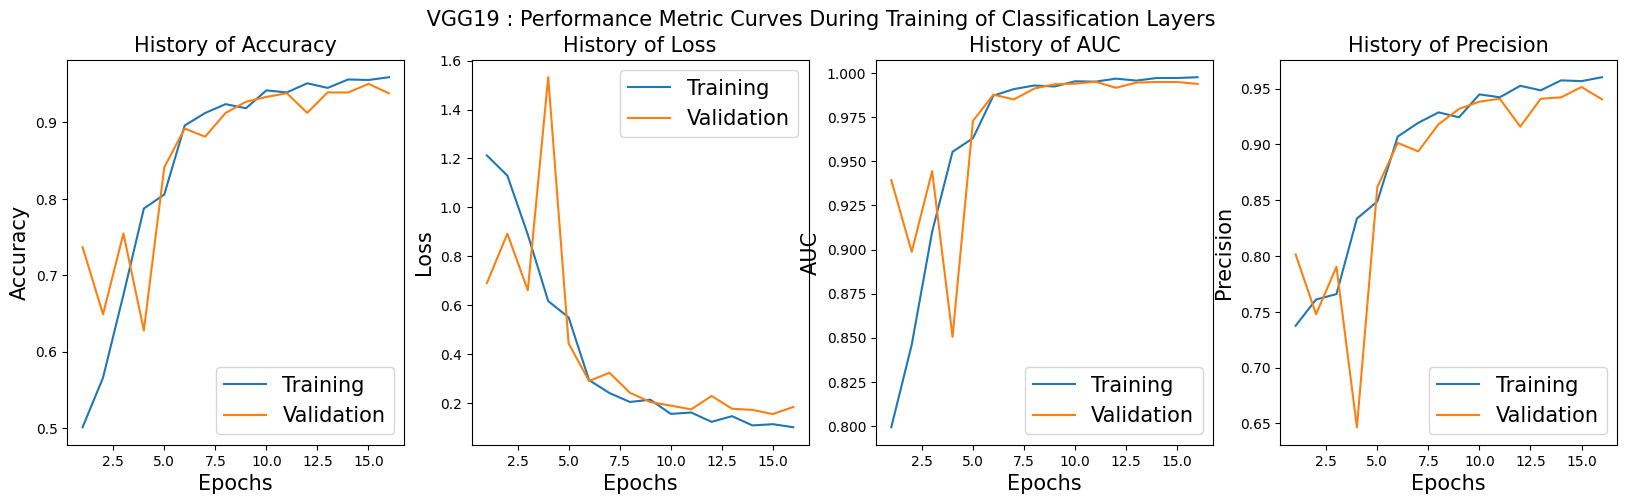

In [ ]:
path = "loss_acc_1.png"
title = " VGG19 : Performance Metric Curves During Training of Classification Layers"
Eval_Plot(
    history_vgg19_scaled_batched.history['accuracy'],history_vgg19_scaled_batched.history['val_accuracy'],
    history_vgg19_scaled_batched.history['loss'],history_vgg19_scaled_batched.history['val_loss'],
    history_vgg19_scaled_batched.history['auc'],history_vgg19_scaled_batched.history['val_auc'],
    history_vgg19_scaled_batched.history['precision'],history_vgg19_scaled_batched.history['val_precision'],
    path, title
)

### Finetune entire vgg19 architecture for 100 epochs

In [ ]:
# Unfreeze the entire layer
for layer in base_model.layers:
    layer.trainable = True


###########################################################################


base_model.trainable = True

# Hyperparameters and Callback Settings
epochs = 100
lr_reduction_factor = 0.5
lr_patience = 5
min_lr = 0.000001
early_stopping_patience = 15
best_model_path = f"{vgg19}VGG19.h5"

lr_reduce = ReduceLROnPlateau(monitor='val_auc',
                              factor=lr_reduction_factor,
                              patience=lr_patience,
                              verbose=1,
                              mode='max',
                              min_lr=min_lr)

early_stopping_cb = EarlyStopping(monitor='val_auc',
                                  patience=early_stopping_patience,
                                  restore_best_weights=True,
                                  verbose=1,
                                  mode="max")

checkpoint_cb = ModelCheckpoint(best_model_path,
                                monitor='val_auc',
                                save_best_only=True,
                                verbose=1,
                                mode="max")

with tf.device('/gpu:0'):
    # Compile the model
    model.compile(optimizer=Adam(learning_rate=0.00001),
                  loss='categorical_crossentropy',
                  metrics=METRICS)

# Display model architecture
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
# Train the model
history_vgg19_scaled_batched_finetuned = model.fit(
    train_dataset_scaled_centered_batched_onehot,
    epochs=epochs,
    validation_data=val_dataset_scaled_centered_batched_onehot,
    verbose = 1,
    class_weight=int_weights,
    callbacks = [lr_reduce, early_stopping_cb, checkpoint_cb],)

Epoch 1/100
154/154 [==============================] - ETA: 0s - loss: 0.1003 - accuracy: 0.9541 - precision: 0.9558 - recall: 0.9527 - auc: 0.9969
Epoch 1: val_auc improved from -inf to 0.99586, saving model to /content/drive/MyDrive/Medical Data/VGG19/VGG19.h5
154/154 [==============================] - 111s 445ms/step - loss: 0.1003 - accuracy: 0.9541 - precision: 0.9558 - recall: 0.9527 - auc: 0.9969 - val_loss: 0.1533 - val_accuracy: 0.9469 - val_precision: 0.9480 - val_recall: 0.9463 - val_auc: 0.9959 - lr: 1.0000e-05
Epoch 2/100
154/154 [==============================] - ETA: 0s - loss: 0.0862 - accuracy: 0.9656 - precision: 0.9664 - recall: 0.9650 - auc: 0.9984
Epoch 2: val_auc did not improve from 0.99586
154/154 [==============================] - 95s 348ms/step - loss: 0.0862 - accuracy: 0.9656 - precision: 0.9664 - recall: 0.9650 - auc: 0.9984 - val_loss: 0.1537 - val_accuracy: 0.9474 - val_precision: 0.9483 - val_recall: 0.9469 - val_auc: 0.9958 - lr: 1.0000e-05
Epoch 3/100


### Plots

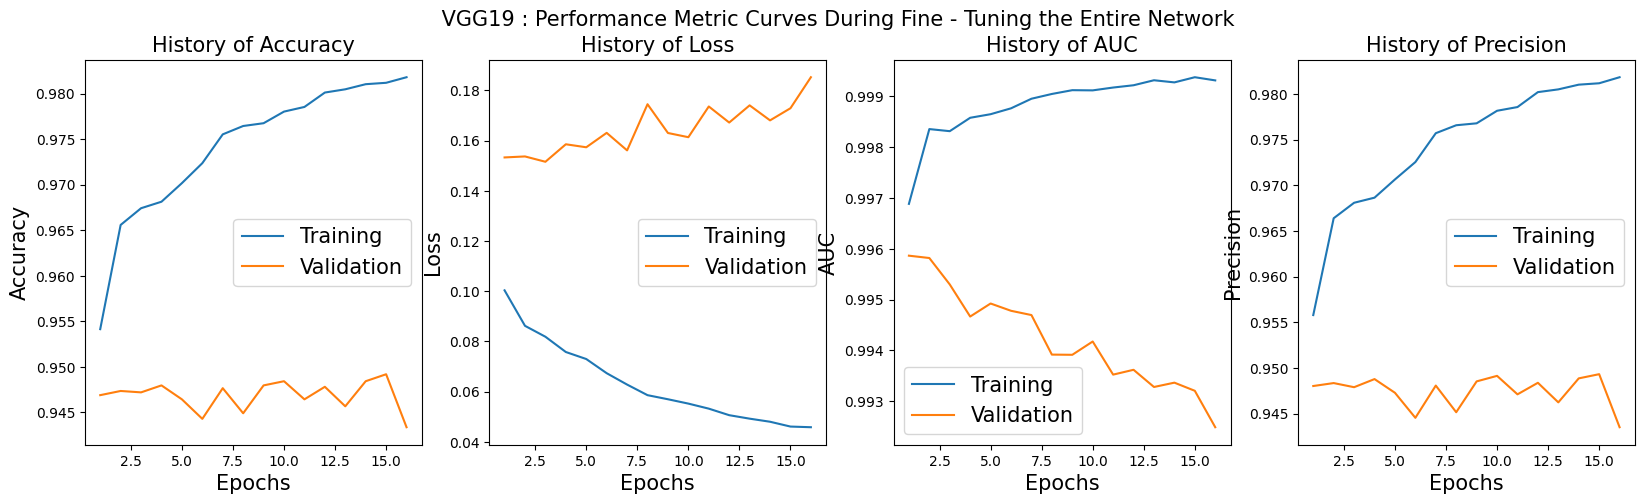

In [ ]:
fname = "loss_acc_2.png"
title = " VGG19 : Performance Metric Curves During Fine - Tuning the Entire Network"
Eval_Plot(
    history_vgg19_scaled_batched_finetuned.history['accuracy'],history_vgg19_scaled_batched_finetuned.history['val_accuracy'],
    history_vgg19_scaled_batched_finetuned.history['loss'],history_vgg19_scaled_batched_finetuned.history['val_loss'],
    history_vgg19_scaled_batched_finetuned.history['auc'],history_vgg19_scaled_batched_finetuned.history['val_auc'],
    history_vgg19_scaled_batched_finetuned.history['precision'],history_vgg19_scaled_batched_finetuned.history['val_precision'],
    fname, title
)

In [ ]:
from tensorflow.keras.models import clone_model

best_model_path = f"{vgg19}VGG19.h5"
# Clone the model architecture
model_prediction = clone_model(model)

# Load the weights into the new model
model_prediction.load_weights(best_model_path)
model.load_weights(f'{best_model_path}')

In [ ]:
# Getting predictions
predictions = model.predict(test_dataset_scaled_centered_batched_onehot)
y_pred = predictions.argmax(axis=-1)

# Retrieving labels from dataset
y_labels_list = []
for _, labels in test_dataset_scaled_centered_batched_onehot:
    # Here, we're assuming that the labels are one-hot encoded
    # So, we get the integer label for each sample in the batch
    y_labels_list.append(tf.argmax(labels, axis=-1))

# Stacking batches together
y_label = tf.concat(y_labels_list, axis=0).numpy()

# Retrieve class names from the ClassName_Dict_Label
class_Names = [class_name for class_name, _ in sorted(ClassName_Dict_Label.items(), key=lambda item: item[1])]

52/52 [==============================] - 839s 16s/step


In [ ]:
assert y_pred.shape == y_label.shape

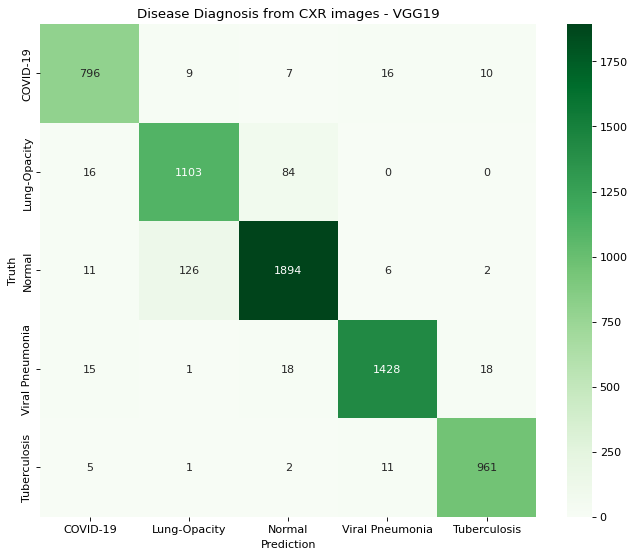

In [ ]:
Confusion_Matrix_Heatmap(y_label, y_pred, class_Names, f"HeatMap.png", "VGG19")

In [ ]:
print(classification_report(y_label, y_pred))

              precision    recall  f1-score   support

           0       0.94      0.95      0.95       838
           1       0.89      0.92      0.90      1203
           2       0.94      0.93      0.94      2039
           3       0.98      0.96      0.97      1480
           4       0.97      0.98      0.98       980

    accuracy                           0.95      6540
   macro avg       0.95      0.95      0.95      6540
weighted avg       0.95      0.95      0.95      6540



### Scores

In [ ]:
with tf.device('/gpu:0'):
    # Compile the model
    model.compile(optimizer=Adam(learning_rate=0.00001),
                  loss='categorical_crossentropy',
                  metrics=METRICS)

scores_VGG19 = model.evaluate(test_dataset_scaled_centered_batched_onehot)

52/52 [==============================] - 47s 901ms/step - loss: 0.1598 - accuracy: 0.9453 - precision: 0.9463 - recall: 0.9434 - auc: 0.9949


In [ ]:
print(f"Accuracy in test set  : {scores_VGG19[1]}")
print(f"Precision in test set : {scores_VGG19[2]}")
print(f"Recall in test set    : {scores_VGG19[3]}")
print(f"AUC in test set       : {scores_VGG19[4]}")
# print(f"F1 Metric in test set : {scores_VGG19[5]}")

Accuracy in test set  : 0.9452599287033081
Precision in test set : 0.946319043636322
Recall in test set    : 0.9434250593185425
AUC in test set       : 0.9949032068252563


In [ ]:
import pandas as pd
Scores = pd.DataFrame([scores_VGG19], columns = ["Loss", "Test Accuracy", "Precision", "Recall", "AUC"])
Scores


,Loss,Test Accuracy,Precision,Recall,AUC
0,0.159846,0.94526,0.946319,0.943425,0.994903


In [ ]:
Scores.to_csv(f"{vgg19}score.csv")

In [ ]:
# del model

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

# GradCam, activation Visualisation

In [ ]:
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()


def make_gradcam_heatmap_new(img_array, model, last_conv_layer_name, pred_index=None):
    # First, create a model that maps the input image to the activations of the last conv layer
    last_conv_layer = model.get_layer(last_conv_layer_name)
    last_conv_layer_model = tf.keras.Model(model.inputs, last_conv_layer.output)

    # Second, create a model that maps the activations of the last conv layer to the final class predictions
    classifier_input = tf.keras.Input(shape=last_conv_layer.output.shape[1:])
    x = classifier_input

    # Loop through layers from the next of last_conv_layer to model's output
    for layer_name in [layer.name for layer in model.layers][model.layers.index(last_conv_layer) + 1:]:
        x = model.get_layer(layer_name)(x)

    classifier_model = tf.keras.Model(classifier_input, x)

    # Compute gradient of the predicted class with regard to the output feature map of the last conv layer
    with tf.GradientTape() as tape:
        # Compute activations of the last conv layer and make the tape watch it
        last_conv_layer_output = last_conv_layer_model(img_array)
        tape.watch(last_conv_layer_output)
        # Compute class predictions
        preds = classifier_model(last_conv_layer_output)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # Compute gradient of the predicted class with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # Pool the gradients over all the axes leaving out the channel dimension
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # Multiply each channel in the feature map array by "how important this channel is" with regard to the top predicted class
    last_conv_layer_output = last_conv_layer_output.numpy()[0]
    pooled_grads = pooled_grads.numpy()
    for i in range(pooled_grads.shape[-1]):
        last_conv_layer_output[:, :, i] *= pooled_grads[i]

    # The channel-wise mean of the resulting feature map is our heatmap of class activation
    heatmap = np.mean(last_conv_layer_output, axis=-1)

    # Normalize heatmap between 0 & 1
    heatmap = np.maximum(heatmap, 0) / np.max(heatmap)
    return heatmap

def grad_cam(input_model, image, cls, layer_name, img_size=(224, 224)):
    image_tensor = tf.convert_to_tensor(image, dtype=tf.float32)  # Convert the image to a Tensor

    # Make sure the image tensor has a batch dimension
    if len(image_tensor.shape) < 4:
        image_tensor = tf.expand_dims(image_tensor, 0)

    intermediate_model = tf.keras.models.Model(inputs=input_model.inputs,
                                               outputs=[input_model.get_layer(layer_name).output, input_model.output])

    with tf.GradientTape() as tape:
        # Ensure that the operations are being tracked
        tape.watch(image_tensor)

        # Forward pass
        conv_output, predictions = intermediate_model(image_tensor)
        y_c = predictions[0, cls]

    # Compute gradients
    grads = tape.gradient(y_c, conv_output)

    output, grads_val = conv_output[0].numpy(), grads[0].numpy()

    weights = np.mean(grads_val, axis=(0, 1))
    cam = np.dot(output, weights)

    cam = cv2.resize(cam, img_size, cv2.INTER_LINEAR)
    cam = np.maximum(cam, 0)
    cam = cam / cam.max()
    return cam

In [ ]:
def get_img_array(img_array):
    # We add a dimension to transform our image array into a "batch"
    # of size (1, 224, 224, 3)
    return np.expand_dims(img_array, axis=0)

import matplotlib.cm as cm
def get_gradcam_img(img, heatmap, alpha=0.4):
    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    # jet = cm("jet")
    jet = plt.colormaps["jet"] # matplotlib.colormaps[name]

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)

    return superimposed_img

# Helper function to rescale the image to be between 0 and 255
def rescale_image(image):
    image = 255 * (image - np.min(image)) / (np.max(image) - np.min(image))
    return np.uint8(image)

In [ ]:
# Choose the last conv layer in your model
last_conv_layer_name = "block5_conv4"  # This is the last convolutional layer in VGG19, adjust if necessary
# Remove last layer's softmax
model.layers[-1].activation = None
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
# Assuming 'model' is your Keras model
for layer in model.layers:
    # Check if the layer uses an activation function
    if hasattr(layer, 'activation'):
        print(f"Layer Name: {layer.name}")
        if layer.activation != None:
          print(f"Activation Function: {layer.activation.__name__}")
          print('------------------------')
        else:
          print("Activation Function Removed.")
          print('------------------------')

Layer Name: block1_conv1
Activation Function: relu
------------------------
Layer Name: block1_conv2
Activation Function: relu
------------------------
Layer Name: block2_conv1
Activation Function: relu
------------------------
Layer Name: block2_conv2
Activation Function: relu
------------------------
Layer Name: block3_conv1
Activation Function: relu
------------------------
Layer Name: block3_conv2
Activation Function: relu
------------------------
Layer Name: block3_conv3
Activation Function: relu
------------------------
Layer Name: block3_conv4
Activation Function: relu
------------------------
Layer Name: block4_conv1
Activation Function: relu
------------------------
Layer Name: block4_conv2
Activation Function: relu
------------------------
Layer Name: block4_conv3
Activation Function: relu
------------------------
Layer Name: block4_conv4
Activation Function: relu
------------------------
Layer Name: block5_conv1
Activation Function: relu
------------------------
Layer Name: 

## Testing Set Grad Cam

In [ ]:
# Assuming the required imports are already present.
# If not, add:
# import numpy as np
# import matplotlib.pyplot as plt
# from tensorflow import keras
# import matplotlib.cm as cm

# Extract sample images
sample_images, sample_labels = next(iter(test_dataset_scaled_centered_batched_onehot.take(1)))
sample_images = sample_images.numpy()
sample_labels = sample_labels.numpy()
print(sample_images.shape, sample_labels.shape)

# Process each image
for img, label in zip(sample_images, sample_labels):
    img_array = get_img_array(img)
    # print(img_array.shape)
    # Print what the top predicted class is
    preds = model_prediction.predict(img_array)
    preds = preds.squeeze()

    min_val = min(preds)
    max_val = max(preds)

    scaled_probabilities = [(value - min_val) / (max_val - min_val) for value in preds]

    # print(scaled_probabilities)

    prob = {
        "Covid-19" : scaled_probabilities[0],
        "Lung Opacity" : scaled_probabilities[1],
        "Normal" : scaled_probabilities[2],
        "Pneumonia" : scaled_probabilities[3],
        "Tuberculosis" : scaled_probabilities[4],
    }
    print(f"Probabilities : \n{prob}")
    # print(f"Predicted : {Label_ClassName_Dict[int(preds.argmax(axis=-1).squeeze())]}")
    # print(f"Actual : {Label_ClassName_Dict[int(label.argmax(axis=-1).squeeze())]}")

    # Generate class activation heatmap
    # heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)
    cls = np.argmax(preds)
    # print(cls)
    heatmap = grad_cam(model, img_array, cls, last_conv_layer_name)


    # Rescale the original image for visualization
    img_display = rescale_image(img)

    # Use the get_gradcam_img function to superimpose the heatmap on the image
    superimposed_img = get_gradcam_img(img_display, heatmap, alpha=0.7)
    plt.title(f"Ground Truth : {Label_ClassName_Dict[int(label.argmax(axis=-1).squeeze())]}" +
              f"\nPredicted : {Label_ClassName_Dict[int(preds.argmax(axis=-1).squeeze())]}")
    plt.axis("off")
    # Display the superimposed image
    plt.imshow(superimposed_img)
    plt.show()

Output hidden; open in https://colab.research.google.com to view.

## Training Set Gradcam

In [ ]:
# Assuming the required imports are already present.
# If not, add:
# import numpy as np
# import matplotlib.pyplot as plt
# from tensorflow import keras
# import matplotlib.cm as cm

# Extract sample images
sample_images, sample_labels = next(iter(train_dataset_scaled_centered_batched_onehot.take(1)))
sample_images = sample_images.numpy()
sample_labels = sample_labels.numpy()
print(sample_images.shape, sample_labels.shape)

# Process each image
for img, label in zip(sample_images, sample_labels):
    img_array = get_img_array(img)
    print(img_array.shape)
    # Print what the top predicted class is
    preds = model_prediction.predict(img_array)
    preds = preds.squeeze()

    min_val = min(preds)
    max_val = max(preds)

    scaled_probabilities = [(value - min_val) / (max_val - min_val) for value in preds]

    # print(scaled_probabilities)

    prob = {
        "Covid-19" : scaled_probabilities[0],
        "Lung Opacity" : scaled_probabilities[1],
        "Normal" : scaled_probabilities[2],
        "Pneumonia" : scaled_probabilities[3],
        "Tuberculosis" : scaled_probabilities[4],
    }
    print(f"Probabilities : \n{prob}")
    # print(f"Predicted : {Label_ClassName_Dict[int(preds.argmax(axis=-1).squeeze())]}")
    # print(f"Actual : {Label_ClassName_Dict[int(label.argmax(axis=-1).squeeze())]}")

    # Generate class activation heatmap
    heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)


    # Rescale the original image for visualization
    img_display = rescale_image(img)

    # Use the get_gradcam_img function to superimpose the heatmap on the image
    superimposed_img = get_gradcam_img(img_display, heatmap, alpha=0.7)
    plt.title(f"Ground Truth : {Label_ClassName_Dict[int(label.argmax(axis=-1).squeeze())]}" +
              f"\nPredicted : {Label_ClassName_Dict[int(preds.argmax(axis=-1).squeeze())]}")
    plt.axis("off")
    # Display the superimposed image
    plt.imshow(superimposed_img)
    plt.show()

Output hidden; open in https://colab.research.google.com to view.

## Validation Set GradCam

In [ ]:
# Assuming the required imports are already present.
# If not, add:
# import numpy as np
# import matplotlib.pyplot as plt
# from tensorflow import keras
# import matplotlib.cm as cm

# Extract sample images
sample_images, sample_labels = next(iter(val_dataset_scaled_centered_batched_onehot.take(1)))
sample_images = sample_images.numpy()
sample_labels = sample_labels.numpy()
print(sample_images.shape, sample_labels.shape)

# Process each image
for img, label in zip(sample_images, sample_labels):
    img_array = get_img_array(img)
    print(img_array.shape)
    # Print what the top predicted class is
    preds = model_prediction.predict(img_array)
    preds = preds.squeeze()

    min_val = min(preds)
    max_val = max(preds)

    scaled_probabilities = [(value - min_val) / (max_val - min_val) for value in preds]

    # print(scaled_probabilities)

    prob = {
        "Covid-19" : scaled_probabilities[0],
        "Lung Opacity" : scaled_probabilities[1],
        "Normal" : scaled_probabilities[2],
        "Pneumonia" : scaled_probabilities[3],
        "Tuberculosis" : scaled_probabilities[4],
    }
    print(f"Probabilities : \n{prob}")
    # print(f"Predicted : {Label_ClassName_Dict[int(preds.argmax(axis=-1).squeeze())]}")
    # print(f"Actual : {Label_ClassName_Dict[int(label.argmax(axis=-1).squeeze())]}")

    # Generate class activation heatmap
    heatmap = make_gradcam_heatmap_new(img_array, model, last_conv_layer_name)


    # Rescale the original image for visualization
    img_display = rescale_image(img)

    # Use the get_gradcam_img function to superimpose the heatmap on the image
    superimposed_img = get_gradcam_img(img_display, heatmap, alpha=0.8)
    plt.title(f"Ground Truth : {Label_ClassName_Dict[int(label.argmax(axis=-1).squeeze())]}" +
              f"\nPredicted : {Label_ClassName_Dict[int(preds.argmax(axis=-1).squeeze())]}")
    plt.axis("off")
    # Display the superimposed image
    plt.imshow(superimposed_img)
    plt.show()

Output hidden; open in https://colab.research.google.com to view.

# Guided Grad Cam

In [ ]:
@tf.custom_gradient
def guidedRelu(x):
    def grad(dy):
        return tf.cast(dy>0,"float32") * tf.cast(x>0, "float32") * dy
    return tf.nn.relu(x), grad

# Create a new model with modified ReLUs
guided_model = tf.keras.models.clone_model(model, clone_function=lambda l: guidedRelu(l) if isinstance(l, tf.keras.layers.ReLU) else l)

In [ ]:
def guided_backprop(guided_model, img, layer_name):
    # Create a tensor from the image
    img_tensor = tf.convert_to_tensor(img, dtype=tf.float32)

    # Make sure the image tensor has a batch dimension
    if len(img_tensor.shape) < 4:
        img_tensor = tf.expand_dims(img_tensor, 0)

    with tf.GradientTape() as tape:
        tape.watch(img_tensor)
        predictions = guided_model(img_tensor)

        # We can get the most likely class, or we can define it before
        predicted_class = tf.argmax(predictions[0])
        loss = predictions[:, predicted_class]

    grads = tape.gradient(loss, img_tensor)[0]
    return grads.numpy()

def get_guided_gradcam(gradcam_heatmap, guided_backprop_output):
    # Expand dimensions of gradcam_heatmap from (224,224) to (224,224,3)
    expanded_gradcam = np.expand_dims(gradcam_heatmap, axis=-1)
    cam_gb = np.multiply(expanded_gradcam, guided_backprop_output)
    # Summing along the last dimension to reduce the (224, 224, 3, 3) shape to (224, 224, 3)
    cam_gb = np.sum(cam_gb, axis=-1)
    return cam_gb

## Testing Set

In [ ]:
# Assuming the required imports are already present.
# If not, add:
# import numpy as np
# import matplotlib.pyplot as plt
# from tensorflow import keras
# import matplotlib.cm as cm

# Extract sample images
sample_images, sample_labels = next(iter(test_dataset_scaled_centered_batched_onehot.take(1)))
sample_images = sample_images.numpy()
sample_labels = sample_labels.numpy()
print(sample_images.shape, sample_labels.shape)

# Process each image
for img, label in zip(sample_images, sample_labels):
    img_array = get_img_array(img)
    # print(img_array.shape)
    # Print what the top predicted class is
    preds = model_prediction.predict(img_array)
    preds = preds.squeeze()

    min_val = min(preds)
    max_val = max(preds)

    scaled_probabilities = [(value - min_val) / (max_val - min_val) for value in preds]

    # print(scaled_probabilities)

    prob = {
        "Covid-19" : scaled_probabilities[0],
        "Lung Opacity" : scaled_probabilities[1],
        "Normal" : scaled_probabilities[2],
        "Pneumonia" : scaled_probabilities[3],
        "Tuberculosis" : scaled_probabilities[4],
    }
    print(f"Probabilities : \n{prob}")
    # print(f"Predicted : {Label_ClassName_Dict[int(preds.argmax(axis=-1).squeeze())]}")
    # print(f"Actual : {Label_ClassName_Dict[int(label.argmax(axis=-1).squeeze())]}")

    # Generate class activation heatmap
    # heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)
    cls = np.argmax(preds)
    # print(cls)
    heatmap = grad_cam(model, img_array, cls, last_conv_layer_name)
    # Assuming img_array is your original image
    guided_bp = guided_backprop(guided_model, img_array, layer_name=last_conv_layer_name)
    guided_gradcam = get_guided_gradcam(heatmap, guided_bp)

    # Rescale the original image for visualization
    img_display = rescale_image(img)

    # Use the get_gradcam_img function to superimpose the heatmap on the image
    superimposed_img = get_gradcam_img(img_display, guided_gradcam, alpha=0.5)
    plt.title(f"Ground Truth : {Label_ClassName_Dict[int(label.argmax(axis=-1).squeeze())]}" +
              f"\nPredicted : {Label_ClassName_Dict[int(preds.argmax(axis=-1).squeeze())]}")
    plt.axis("off")
    # Display the superimposed image
    plt.imshow(superimposed_img)
    plt.show()

Output hidden; open in https://colab.research.google.com to view.

# Comparison of Activation Visualization Algorithms : GradCam vs Guided Grad Cam

## Testing Set

In [ ]:
# Extract sample images
sample_images, sample_labels = next(iter(test_dataset_scaled_centered_batched_onehot.take(1)))
sample_images = sample_images.numpy()
sample_labels = sample_labels.numpy()
print(sample_images.shape, sample_labels.shape)

# Process each image
for img, label in zip(sample_images, sample_labels):
    img_array = get_img_array(img)
    # print(img_array.shape)
    # Print what the top predicted class is
    preds = model_prediction.predict(img_array)
    preds = preds.squeeze()

    min_val = min(preds)
    max_val = max(preds)

    scaled_probabilities = [(value - min_val) / (max_val - min_val) for value in preds]

    # print(scaled_probabilities)

    prob = {
        "Covid-19" : scaled_probabilities[0],
        "Lung Opacity" : scaled_probabilities[1],
        "Normal" : scaled_probabilities[2],
        "Pneumonia" : scaled_probabilities[3],
        "Tuberculosis" : scaled_probabilities[4],
    }
    print(f"Probabilities : \n{prob}")
    # print(f"Predicted : {Label_ClassName_Dict[int(preds.argmax(axis=-1).squeeze())]}")
    # print(f"Actual : {Label_ClassName_Dict[int(label.argmax(axis=-1).squeeze())]}")

    # Generate class activation heatmap
    # heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)
    cls = np.argmax(preds)
    # print(cls)
    heatmap = grad_cam(model, img_array, cls, last_conv_layer_name)
    # Assuming img_array is your original image
    guided_bp = guided_backprop(guided_model, img_array, layer_name=last_conv_layer_name)
    guided_gradcam = get_guided_gradcam(heatmap, guided_bp)

    # Rescale the original image for visualization
    img_display = rescale_image(img)

    # Create the GradCAM superimposed image
    gradcam_img = get_gradcam_img(img_display, heatmap, alpha=0.5)

    # Create the Guided GradCAM superimposed image
    superimposed_img = get_gradcam_img(img_display, guided_gradcam, alpha=0.5)

    plt.figure(figsize=(15, 5))  # Adjust the figure size

    # Plot original image
    plt.subplot(1, 3, 1)
    plt.imshow(img_display)
    plt.title("Original Image")
    plt.axis("off")

    # Plot GradCAM superimposed image
    plt.subplot(1, 3, 2)
    plt.imshow(gradcam_img)
    plt.title("GradCAM Superimposed")
    plt.axis("off")

    # Plot Guided GradCAM superimposed image
    plt.subplot(1, 3, 3)
    plt.imshow(superimposed_img)
    plt.title("Guided GradCAM Superimposed")
    plt.axis("off")

    # Setting the super title for the entire subplot
    plt.suptitle(f"Ground Truth: {Label_ClassName_Dict[int(label.argmax(axis=-1).squeeze())]}" +
                 f"Predicted: {Label_ClassName_Dict[int(preds.argmax(axis=-1).squeeze())]}")

    plt.tight_layout()
    plt.show()

Output hidden; open in https://colab.research.google.com to view.

## Training Set

In [ ]:
# Extract sample images
sample_images, sample_labels = next(iter(train_dataset_scaled_centered_batched_onehot.take(1)))
sample_images = sample_images.numpy()
sample_labels = sample_labels.numpy()
print(sample_images.shape, sample_labels.shape)

# Process each image
for img, label in zip(sample_images, sample_labels):
    img_array = get_img_array(img)
    # print(img_array.shape)
    # Print what the top predicted class is
    preds = model_prediction.predict(img_array)
    preds = preds.squeeze()

    min_val = min(preds)
    max_val = max(preds)

    scaled_probabilities = [(value - min_val) / (max_val - min_val) for value in preds]

    # print(scaled_probabilities)

    prob = {
        "Covid-19" : scaled_probabilities[0],
        "Lung Opacity" : scaled_probabilities[1],
        "Normal" : scaled_probabilities[2],
        "Pneumonia" : scaled_probabilities[3],
        "Tuberculosis" : scaled_probabilities[4],
    }
    print(f"Probabilities : \n{prob}")
    # print(f"Predicted : {Label_ClassName_Dict[int(preds.argmax(axis=-1).squeeze())]}")
    # print(f"Actual : {Label_ClassName_Dict[int(label.argmax(axis=-1).squeeze())]}")

    # Generate class activation heatmap
    # heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)
    cls = np.argmax(preds)
    # print(cls)
    heatmap = grad_cam(model, img_array, cls, last_conv_layer_name)
    # Assuming img_array is your original image
    guided_bp = guided_backprop(guided_model, img_array, layer_name=last_conv_layer_name)
    guided_gradcam = get_guided_gradcam(heatmap, guided_bp)

    # Rescale the original image for visualization
    img_display = rescale_image(img)

    # Create the GradCAM superimposed image
    gradcam_img = get_gradcam_img(img_display, heatmap, alpha=0.5)

    # Create the Guided GradCAM superimposed image
    superimposed_img = get_gradcam_img(img_display, guided_gradcam, alpha=0.5)

    plt.figure(figsize=(15, 5))  # Adjust the figure size

    # Plot original image
    plt.subplot(1, 3, 1)
    plt.imshow(img_display)
    plt.title("Original Image")
    plt.axis("off")

    # Plot GradCAM superimposed image
    plt.subplot(1, 3, 2)
    plt.imshow(gradcam_img)
    plt.title("GradCAM Superimposed")
    plt.axis("off")

    # Plot Guided GradCAM superimposed image
    plt.subplot(1, 3, 3)
    plt.imshow(superimposed_img)
    plt.title("Guided GradCAM Superimposed")
    plt.axis("off")

    # Setting the super title for the entire subplot
    plt.suptitle(f"Ground Truth: {Label_ClassName_Dict[int(label.argmax(axis=-1).squeeze())]}" +
                 f"Predicted: {Label_ClassName_Dict[int(preds.argmax(axis=-1).squeeze())]}")

    plt.tight_layout()
    plt.show()

Output hidden; open in https://colab.research.google.com to view.